In [7]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Building the Neural Network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam

# Optimizing the Hyperparameters
from hyperas import optim
from hyperas.distributions import choice, uniform, conditional

In [2]:
def load_data():
    print('Loading data...')
    loaded = np.load('data/A00-139_first_10000.npz')
    boards = loaded['arr_0']
    targets = loaded['arr_1']
    print('Data loaded.  Splitting data...')
    b_train, b_test, t_train, t_test = train_test_split(boards, targets, test_size=0.25)
    print('Returning output...')
    return b_train, b_test, t_train, t_test

In [3]:
b_train, b_test, t_train, t_test = load_data()

Loading data...
Data loaded.  Splitting data...
Returning output...


### Learning to Play Chess

The initial objective in building the model will to be teach the agent how to play chess by example.  [@oshri2016predicting] offers one method for doing this by using convolutional neural networks to make predictions about the next move based on the board position.  They did this by training seven CNNs, the predict how desirable it was for each piece to move.  The last six were trained to predict the coordinates of a probable move for each piece.  Because of the differing objectives we will need to actually split out the data set into 7 different data sets, each containing only the board positions that are relavent to that CNN.

This brings us to an important point about the CNN model.  We are not going to be giving it whole games at a time, rather pulling out only the specific board states that are relavent to that model. If we consider conceptually what this agent might be learning, because we are removing the flow of the actual game, this agent will probably not be able to reason about long term strategy very well.  Instead its creating a probability model of possible moves (and potentially impossible moves) based on a position. We might interpret this as learning the basic rules of the game, but certainly our agent isn't learning very much grant strategy.  

Long term, we will seek to combine the intuition our agent will build about chess from the CNNs along with other deep learning approaches better suited to learning strategic choices.  These later agents may very likely required the data to be formatted in a different way, but that's work for later.

#### Design Choices

##### Split by color or not
There are a series of choices that I will have to make in creating this model.  First, given that I am already cutting down the data set considerably to only moves for particular pieces, should I split the data further down to just white or black and train individual models.  This is a tough one, because there is both undeniable differences in how black has to play the game, particularly in the start of the game when they are behind a tempo automatically, and similarities in how the game is played no matter which color you are.  All that considered, the goal of *this particular model* is to learn legal and reasonable moves give a board state.  These are not the most strategic moves, as this model will have no conception of the temporal aspect of chess, and so I don't think we need to concern this model with the color of the pieces.

### Preparing the data for CNNs

In [4]:
def b_to_w(boards):
    return np.fliplr(boards)*-1

def convert_colors(b=b_train, t=t_train):
    move_made_by = t[:, 0]
    bbs = b[(move_made_by == "b")]
    bms = t[(move_made_by == 'b')]
    wbs = b[(move_made_by == "w")]
    wms = t[(move_made_by == 'w')]
    bbs_t = np.array([b_to_w(b) for b in bbs])
    bs = np.concatenate([bbs_t, wbs], axis=0)
    ms = np.concatenate([bms, wms], axis=0)
    return bs, ms

def convert_coord(a):
    #print(a)
    board = np.zeros((8, 8))
    board[int(a[0]),int(a[1])] = 1
    return board

def move_selector_data(bs, ms):
    # piece selector data consists of all available board positions. The predictor is the index of the piece
    # that moved (0 through 5).  
    y = np.apply_along_axis(func1d=convert_coord, axis=1, arr=ms[:, 2:4])
    #print(y.shape)
    print("The Move Selector data set contains {} boards".format(y.shape[0]))
    return bs.astype('int'), y.reshape(y.shape[0], 64)

def single_piece_selector_data(bs, ms, piece):
    pieces = ['Pawn', 'Rook', 'Knight', 'Bishop', 'Queen', 'King']
    move_selector = ms[:, 1]
    piece_bs = bs[move_selector == piece]
    piece_ms = ms[move_selector == piece, 4:6]
    y = np.apply_along_axis(func1d=convert_coord, axis=1, arr=piece_ms)
    print("The {} Move Selector data set contains {} boards".format(pieces[int(piece)], piece_ms.shape[0]))
    return piece_bs.astype('int'), y.reshape(y.shape[0], 64)

In [5]:
X_train, y_train = convert_colors()
ms_X_tr, ms_y_tr = move_selector_data(X_train, y_train)
pawn_X_tr, pawn_y_tr = single_piece_selector_data(X_train, y_train, '0') 
rook_X_tr, rook_y_tr = single_piece_selector_data(X_train, y_train, '1')
knight_X_tr, knight_y_tr = single_piece_selector_data(X_train, y_train, '2')
bishop_X_tr, bishop_y_tr = single_piece_selector_data(X_train, y_train, '3')
queen_X_tr, queen_y_tr = single_piece_selector_data(X_train, y_train, '4')
king_X_tr, king_y_tr = single_piece_selector_data(X_train, y_train, '5')

The Move Selector data set contains 633586 boards
The Pawn Move Selector data set contains 166469 boards
The Rook Move Selector data set contains 109670 boards
The Knight Move Selector data set contains 111631 boards
The Bishop Move Selector data set contains 96784 boards
The Queen Move Selector data set contains 73296 boards
The King Move Selector data set contains 75736 boards


In [6]:
X_test, y_test = convert_colors(b_test, t_test)
ms_X_test, ps_y_test = move_selector_data(X_test, y_test)
pawn_X_test, pawn_y_test = single_piece_selector_data(X_test, y_test, '0') 
rook_X_test, rook_y_test = single_piece_selector_data(X_test, y_test, '1')
knight_X_test, knight_y_test = single_piece_selector_data(X_test, y_test, '2')
bishop_X_test, bishop_y_test = single_piece_selector_data(X_test, y_test, '3')
queen_X_test, queen_y_test = single_piece_selector_data(X_test, y_test, '4')
king_X_test, king_y_test = single_piece_selector_data(X_test, y_test, '5')

The Move Selector data set contains 211196 boards
The Pawn Move Selector data set contains 55455 boards
The Rook Move Selector data set contains 36535 boards
The Knight Move Selector data set contains 37092 boards
The Bishop Move Selector data set contains 32666 boards
The Queen Move Selector data set contains 24435 boards
The King Move Selector data set contains 25013 boards


In [13]:
def move_selector_model(kernal_size=(3, 3), conv_layers=2, dense_layers=2):
    BOARD_CHANNELS = 6
    BOARD_ROWS = 8
    BOARD_COLS = 8    
    NB_CLASSES = 64

    # network
    model = Sequential()
    model.add(Conv2D(32, kernal_size, padding='same',
    input_shape=(BOARD_CHANNELS, BOARD_COLS, BOARD_ROWS)))
    model.add(Activation('relu'))
    if conv_layers > 1:
        for i in range(conv_layers-1):
            model.add(Conv2D(32, kernal_size, padding='same'))
            model.add(Activation('relu'))
    
    model.add(Flatten())
    if dense_layers > 1:
        for i in range(dense_layers-1):
            model.add(Dense(64))
            model.add(Activation("relu")) 
    
    model.add(Dense(NB_CLASSES))
    model.add(Activation("softmax"))
    return model

def compile_and_fit_ms_model(X_train, y_train, model):
    OPTIMIZER = Adam()
    BATCH_SIZE = 128
    NB_EPOCH = 15
    VALIDATION_SPLIT = 0.2    
    VERBOSE = 1
    
    model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER, metrics=["accuracy"])
    history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE, epochs=NB_EPOCH,
                    verbose=VERBOSE, validation_split=VALIDATION_SPLIT)
    return model, history

def score_model(X_test, y_test, model):
    VERBOSE = 1
    score = model.evaluate(X_test, y_test, verbose=VERBOSE)
    print("Test score:", score[0])
    print('Test accuracy:', score[1])
    return model, score

def plot_acc_loss(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [35]:
ms_model, ms_history = compile_and_fit_ms_model(ps_X_tr, ps_y_tr, move_selector_model(conv_layers=1))
ms_model, ms_score = score_model(ps_X_test, ps_y_test, ms_model)

Train on 506868 samples, validate on 126718 samples
Epoch 1/15
506868/506868 [==============================] - 21s - loss: 2.7573 - acc: 0.2135 - val_loss: 2.6220 - val_acc: 0.1891
Epoch 2/15
506868/506868 [==============================] - 19s - loss: 2.3838 - acc: 0.2578 - val_loss: 2.5961 - val_acc: 0.1881
Epoch 3/15
506868/506868 [==============================] - 19s - loss: 2.3206 - acc: 0.2713 - val_loss: 2.5519 - val_acc: 0.1956
Epoch 4/15
506868/506868 [==============================] - 19s - loss: 2.2845 - acc: 0.2790 - val_loss: 2.5746 - val_acc: 0.1913
Epoch 5/15
506868/506868 [==============================] - 19s - loss: 2.2563 - acc: 0.2853 - val_loss: 2.5064 - val_acc: 0.2068
Epoch 6/15
506868/506868 [==============================] - 20s - loss: 2.2329 - acc: 0.2902 - val_loss: 2.4810 - val_acc: 0.2143
Epoch 7/15
506868/506868 [==============================] - 19s - loss: 2.2114 - acc: 0.2958 - val_loss: 2.4469 - val_acc: 0.2222
Epoch 8/15
506868/506868 [============

NameError: name 'model' is not defined

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


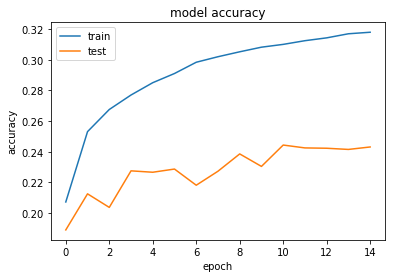

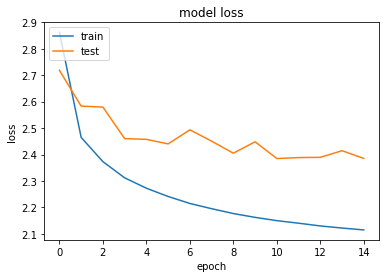

In [255]:
plot_acc_loss(ms_history)

In [23]:
def piece_selector_model(kernal_size=(3, 3), conv_layers=2, dense_layers=2):
    BOARD_CHANNELS = 6
    BOARD_ROWS = 8
    BOARD_COLS = 8    
    NB_CLASSES = 64

    # network
    model = Sequential()
    model.add(Conv2D(32, kernal_size, padding='same',
                     input_shape=(BOARD_CHANNELS, BOARD_COLS, BOARD_ROWS)))
    model.add(Activation('relu'))
    if conv_layers > 1:
        for i in range(conv_layers-1):
            model.add(Conv2D(32, kernal_size, padding='same'))
            model.add(Activation('relu'))
    
    model.add(Flatten())
    if dense_layers > 1:
        for i in range(dense_layers-1):
            model.add(Dense(64))
            model.add(Activation("relu")) 
    
    model.add(Dense(NB_CLASSES))
    model.add(Activation("softmax"))
    return model

In [26]:
pawn_model, pawn_history = compile_and_fit_ms_model(pawn_X_tr, pawn_y_tr, piece_selector_model())
pawn_model, pawn_score = score_model(pawn_X_test, pawn_y_test, pawn_model)

Train on 133304 samples, validate on 33326 samples
Epoch 1/15
133304/133304 [==============================] - 6s - loss: 2.8108 - acc: 0.2113 - val_loss: 2.6632 - val_acc: 0.2320
Epoch 2/15
133304/133304 [==============================] - 5s - loss: 2.3871 - acc: 0.3031 - val_loss: 2.4672 - val_acc: 0.2661
Epoch 3/15
133304/133304 [==============================] - 5s - loss: 2.2075 - acc: 0.3376 - val_loss: 2.3585 - val_acc: 0.2810
Epoch 4/15
133304/133304 [==============================] - 5s - loss: 2.0905 - acc: 0.3605 - val_loss: 2.2880 - val_acc: 0.2993
Epoch 5/15
133304/133304 [==============================] - 5s - loss: 1.9970 - acc: 0.3804 - val_loss: 2.2048 - val_acc: 0.3095
Epoch 6/15
133304/133304 [==============================] - 5s - loss: 1.9278 - acc: 0.3953 - val_loss: 2.2013 - val_acc: 0.3075
Epoch 7/15
133304/133304 [==============================] - 5s - loss: 1.8748 - acc: 0.4079 - val_loss: 2.1342 - val_acc: 0.3317
Epoch 8/15
133304/133304 [====================

In [27]:
rook_model, rook_history = compile_and_fit_ms_model(rook_X_tr, rook_y_tr, piece_selector_model())
rook_model, rook_score = score_model(rook_X_test, rook_y_test, rook_model)

Train on 87668 samples, validate on 21918 samples
Epoch 1/15
87668/87668 [==============================] - 4s - loss: 3.4310 - acc: 0.1382 - val_loss: 3.2534 - val_acc: 0.1432
Epoch 2/15
87668/87668 [==============================] - 3s - loss: 2.9937 - acc: 0.1960 - val_loss: 3.0625 - val_acc: 0.1711
Epoch 3/15
87668/87668 [==============================] - 3s - loss: 2.8152 - acc: 0.2214 - val_loss: 2.9259 - val_acc: 0.1905
Epoch 4/15
87668/87668 [==============================] - 3s - loss: 2.6995 - acc: 0.2371 - val_loss: 2.9244 - val_acc: 0.1747
Epoch 5/15
87668/87668 [==============================] - 3s - loss: 2.6143 - acc: 0.2525 - val_loss: 2.8942 - val_acc: 0.1722
Epoch 6/15
87668/87668 [==============================] - 3s - loss: 2.5494 - acc: 0.2652 - val_loss: 2.8738 - val_acc: 0.1747
Epoch 7/15
87668/87668 [==============================] - 3s - loss: 2.4945 - acc: 0.2766 - val_loss: 2.8277 - val_acc: 0.1981
Epoch 8/15
87668/87668 [==============================] - 3s 

In [28]:
knight_model, knightn_history = compile_and_fit_ms_model(knight_X_tr, knight_y_tr, piece_selector_model())
knight_model, knight_score = score_model(knight_X_test, knight_y_test, knight_model)

Train on 89354 samples, validate on 22339 samples
Epoch 1/15
89354/89354 [==============================] - 4s - loss: 2.7347 - acc: 0.2836 - val_loss: 2.5871 - val_acc: 0.2830
Epoch 2/15
89354/89354 [==============================] - 3s - loss: 2.2138 - acc: 0.3736 - val_loss: 2.3892 - val_acc: 0.3142
Epoch 3/15
89354/89354 [==============================] - 3s - loss: 2.0197 - acc: 0.4071 - val_loss: 2.2338 - val_acc: 0.3445
Epoch 4/15
89354/89354 [==============================] - 3s - loss: 1.9029 - acc: 0.4318 - val_loss: 2.2335 - val_acc: 0.3429
Epoch 5/15
89354/89354 [==============================] - 3s - loss: 1.8203 - acc: 0.4495 - val_loss: 2.1641 - val_acc: 0.3611
Epoch 6/15
89354/89354 [==============================] - 3s - loss: 1.7532 - acc: 0.4648 - val_loss: 2.1455 - val_acc: 0.3689
Epoch 7/15
89354/89354 [==============================] - 3s - loss: 1.6981 - acc: 0.4785 - val_loss: 2.1210 - val_acc: 0.3816
Epoch 8/15
89354/89354 [==============================] - 3s 

In [33]:
bishop_model, bishop_history = compile_and_fit_ms_model(bishop_X_tr, bishop_y_tr, piece_selector_model())
bishop_model, bishop_score = score_model(bishop_X_test, bishop_y_test, bishop_model)

Train on 77617 samples, validate on 19405 samples
Epoch 1/15
77617/77617 [==============================] - 3s - loss: 3.0250 - acc: 0.2313 - val_loss: 2.9176 - val_acc: 0.2256
Epoch 2/15
77617/77617 [==============================] - 3s - loss: 2.5479 - acc: 0.3166 - val_loss: 2.7765 - val_acc: 0.2389
Epoch 3/15
77617/77617 [==============================] - 3s - loss: 2.3628 - acc: 0.3471 - val_loss: 2.6652 - val_acc: 0.2596
Epoch 4/15
77617/77617 [==============================] - 3s - loss: 2.2412 - acc: 0.3682 - val_loss: 2.5579 - val_acc: 0.2846
Epoch 5/15
77617/77617 [==============================] - 3s - loss: 2.1466 - acc: 0.3860 - val_loss: 2.5408 - val_acc: 0.2914
Epoch 6/15
77617/77617 [==============================] - 3s - loss: 2.0722 - acc: 0.3996 - val_loss: 2.5371 - val_acc: 0.2875
Epoch 7/15
77617/77617 [==============================] - 3s - loss: 2.0094 - acc: 0.4145 - val_loss: 2.5053 - val_acc: 0.2990
Epoch 8/15
77617/77617 [==============================] - 3s 

In [32]:
queen_model, queen_history = compile_and_fit_ms_model(queen_X_tr, queen_y_tr, piece_selector_model())
queen_model, queen_score = score_model(queen_X_test, queen_y_test, queen_model)

Train on 58496 samples, validate on 14624 samples
Epoch 1/15
58496/58496 [==============================] - 2s - loss: 3.6736 - acc: 0.1013 - val_loss: 3.5018 - val_acc: 0.1211
Epoch 2/15
58496/58496 [==============================] - 2s - loss: 3.2733 - acc: 0.1647 - val_loss: 3.3116 - val_acc: 0.1565
Epoch 3/15
58496/58496 [==============================] - 2s - loss: 3.0995 - acc: 0.1936 - val_loss: 3.2639 - val_acc: 0.1515
Epoch 4/15
58496/58496 [==============================] - 2s - loss: 2.9845 - acc: 0.2145 - val_loss: 3.1687 - val_acc: 0.1703
Epoch 5/15
58496/58496 [==============================] - 2s - loss: 2.8914 - acc: 0.2300 - val_loss: 3.1820 - val_acc: 0.1630
Epoch 6/15
58496/58496 [==============================] - 2s - loss: 2.8171 - acc: 0.2445 - val_loss: 3.1979 - val_acc: 0.1535
Epoch 7/15
58496/58496 [==============================] - 2s - loss: 2.7456 - acc: 0.2585 - val_loss: 3.1575 - val_acc: 0.1707
Epoch 8/15
58496/58496 [==============================] - 2s 

In [34]:
king_model, king_history = compile_and_fit_ms_model(king_X_tr, king_y_tr, piece_selector_model())
king_model, king_score = score_model(king_X_test, king_y_test, king_model)

Train on 60428 samples, validate on 15107 samples
Epoch 1/15
60428/60428 [==============================] - 3s - loss: 2.6376 - acc: 0.2627 - val_loss: 2.3612 - val_acc: 0.2383
Epoch 2/15
60428/60428 [==============================] - 2s - loss: 1.9676 - acc: 0.3537 - val_loss: 2.1036 - val_acc: 0.2872
Epoch 3/15
60428/60428 [==============================] - 2s - loss: 1.8140 - acc: 0.3891 - val_loss: 2.1382 - val_acc: 0.2605
Epoch 4/15
60428/60428 [==============================] - 2s - loss: 1.7217 - acc: 0.4133 - val_loss: 2.0629 - val_acc: 0.2844
Epoch 5/15
60428/60428 [==============================] - 2s - loss: 1.6470 - acc: 0.4353 - val_loss: 1.9992 - val_acc: 0.2994
Epoch 6/15
60428/60428 [==============================] - 2s - loss: 1.5833 - acc: 0.4563 - val_loss: 1.9028 - val_acc: 0.3428
Epoch 7/15
60428/60428 [==============================] - 2s - loss: 1.5306 - acc: 0.4716 - val_loss: 1.9396 - val_acc: 0.3367
Epoch 8/15
60428/60428 [==============================] - 2s 